In [25]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

# Введение

Разработка демонстрационной версии поиска изображений по запросу

В рамках проекта разработана демонстрационная версия системы поиска изображений на основе текстовых запросов. Для реализации данной системы была обучена модель, которая преобразует изображения и текстовые запросы в векторные представления и оценивает степень их соответствия по шкале от 0 до 1.

Цели и задачи:
1. Разработка системы, способной преобразовывать изображения и текст в векторные представления.
2. Обучение модели на основе выбранных архитектур нейронных сетей.
3. Оценка соответствия текстового запроса и изображения с помощью модели.

Ожидаемые результаты:
Система будет способна принимать текстовые запросы и выводить изображения, наиболее соответствующие этим запросам, с указанием степени их соответствия.

# Исследовательский анализ данных

Данные можно загрузить <a href="https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip">тут</a>

In [32]:
def print_image_dir(path, count=4):
    # Поддерживаемые форматы изображений
    supported_formats = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')

    # Получение списка файлов в папке с поддерживаемыми форматами
    image_files = [file for file in os.listdir(path) if file.lower().endswith(supported_formats)]

    # Проверка, есть ли хотя бы 4 изображения
    if len(image_files) < count:
        print(f"В папке найдено только изображений.")
        selected_images = image_files
    else:
        selected_images = image_files[:count]

    # Отображение изображений
    plt.figure(figsize=(10, 10))  # Размер фигуры можно изменить по необходимости

    for idx, image_name in enumerate(selected_images, 1):
        image_path = os.path.join(path, image_name)
        try:
            img = Image.open(image_path)
            plt.subplot(1, 4, idx)  # Расположение в сетке 2x2
            plt.imshow(img)
            plt.title(image_name)
            plt.axis('off')
        except Exception as e:
            print(f"Не удалось открыть изображение {image_name}: {e}")

    plt.tight_layout()
    plt.show()

## Загрузка данных

In [22]:
train_dataset = pd.read_csv('dataset/train_dataset.csv')
test_queries = pd.read_csv('dataset/test_queries.csv', sep='|', index_col=0)
crowd_annotations = pd.read_csv('dataset/CrowdAnnotations.tsv', sep='\t', header=None)
expert_annotations = pd.read_csv('dataset/ExpertAnnotations.tsv', sep='\t', header=None)
test_images = pd.read_csv('dataset/test_images.csv', sep='|')

## Данные для обучения

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

In [14]:
train_dataset.head()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [13]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


В папке `train_images` содержатся изображения для тренировки модели.

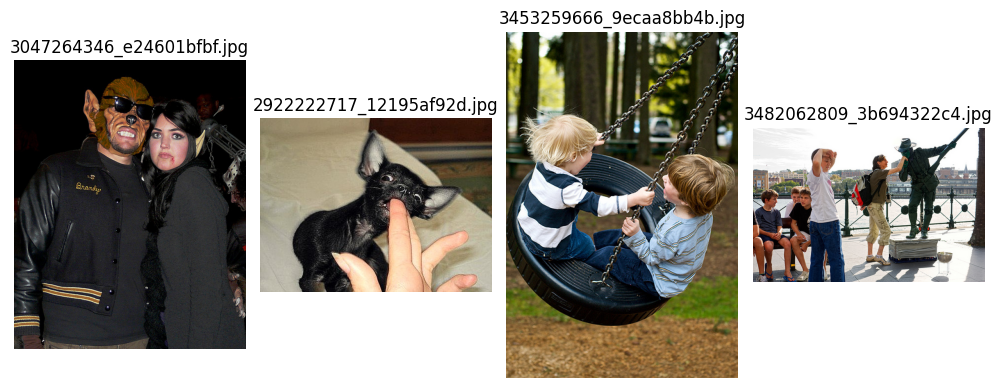

In [33]:
print_image_dir('dataset/train_images')

## Данные для тестирования

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

In [15]:
test_queries.head()

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [16]:
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


В папке `test_images` содержатся изображения для тестирования модели.

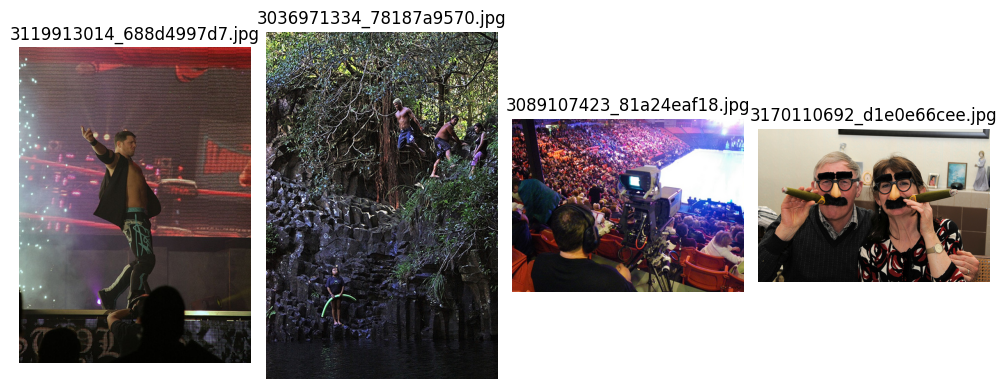

In [34]:
print_image_dir('dataset/test_images')

## Данные по соответствию изображения и описания

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.


In [18]:
crowd_annotations.head()

,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


In [19]:
crowd_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       47830 non-null  object 
 1   1       47830 non-null  object 
 2   2       47830 non-null  float64
 3   3       47830 non-null  int64  
 4   4       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


## Данные по соответствию изображения

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

In [23]:
expert_annotations.head()

,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [24]:
expert_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5822 non-null   object
 1   1       5822 non-null   object
 2   2       5822 non-null   int64 
 3   3       5822 non-null   int64 
 4   4       5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


# Проверка данных

# Векторизация изображений

# Векторизация текстов

# Объединение векторовОбъединение векторов

# Обучение модели предсказания соответствия

# Тестирование модели

# Выводы